1. acc很高，但有些过拟合，如何处理？
2. test上的acc不再提升，如何解决？

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils, regularizers
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras import backend as K

from utils.data import load_capg_data, CapgDBName, LoadMode

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)  # set this TensorFlow session as the default session for Keras

In [2]:
# set const values
weights_file = './models/capg_cnn2_weights.h5'
model_file = './models/capg_cnn2_model.h5'

In [3]:
# load capg dba data
x, y, category = load_capg_data(CapgDBName.dba, LoadMode.flat_frame)
y = utils.to_categorical(y - 1, category)

print(x.shape)
print(y.shape)

(1440000, 16, 8, 1)
(1440000, 8)


In [4]:
'''
根据论文实现的模型
TODO:Locallyconnected2D可能不尽人意
'''
model = Sequential()

model.add(BatchNormalization(input_shape=[16, 8, 1], momentum=0.9))

model.add(Conv2D(64, (3, 3), use_bias=False,
                 padding='same', strides=(1, 1)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), use_bias=False,
                 padding='same', strides=(1, 1)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))

model.add(LocallyConnected2D(64, (1, 1), use_bias=False))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))

model.add(LocallyConnected2D(64, (1, 1), use_bias=False))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units=512, use_bias=False))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=512, use_bias=False))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(units=128, use_bias=False))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))

model.add(Dense(units=8, use_bias=True))
model.add(Activation('softmax'))

if os.path.exists(model_file):
    print('load weights from a trained model')
    model.load_weights(model_file, by_name=True)
else:
    print('train a new model')

train a new model


In [5]:
sgd = SGD(momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v2 (Batc (None, 16, 8, 1)          4         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 8, 64)         576       
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 16, 8, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16, 8, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 8, 64)         36864     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 16, 8, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 8, 64)         0

In [6]:
# tb_callback = TensorBoard(log_dir='./logs/lstm/',
#                           histogram_freq=1,
#                           batch_size=32,
#                           write_grads=True,
#                           update_freq='batch')

In [7]:
def learning_rate_tuner(epoch):
    lr = 0.1
    if 20 <= epoch < 40:
        lr = 0.01
    elif epoch >= 40:
        lr = 0.001
    return lr

lr_scheduler = LearningRateScheduler(learning_rate_tuner)

In [8]:
history = model.fit(x, y, batch_size=256, epochs=60, validation_split=0.1,
                    callbacks=[lr_scheduler])

Train on 1296000 samples, validate on 144000 samples
Epoch 1/60
1296000/1296000 [==============================] - 227s 175us/sample - loss: 1.2018 - accuracy: 0.5336 - val_loss: 0.8113 - val_accuracy: 0.6831
Epoch 2/60
1296000/1296000 [==============================] - 223s 172us/sample - loss: 0.7982 - accuracy: 0.7013 - val_loss: 0.6230 - val_accuracy: 0.7636
Epoch 3/60
1296000/1296000 [==============================] - 222s 172us/sample - loss: 0.6851 - accuracy: 0.7460 - val_loss: 0.5723 - val_accuracy: 0.7829
Epoch 4/60
1296000/1296000 [==============================] - 222s 171us/sample - loss: 0.6206 - accuracy: 0.7705 - val_loss: 0.5160 - val_accuracy: 0.8070
Epoch 5/60
1296000/1296000 [==============================] - 222s 172us/sample - loss: 0.5754 - accuracy: 0.7875 - val_loss: 0.4829 - val_accuracy: 0.8202
Epoch 6/60
1296000/1296000 [==============================] - 222s 171us/sample - loss: 0.5390 - accuracy: 0.8024 - val_loss: 0.4810 - val_accuracy: 0.8159
Epoch 7/60


Epoch 53/60
1296000/1296000 [==============================] - 227s 175us/sample - loss: 0.2738 - accuracy: 0.9001 - val_loss: 0.3445 - val_accuracy: 0.8762
Epoch 54/60
1296000/1296000 [==============================] - 227s 175us/sample - loss: 0.2742 - accuracy: 0.8998 - val_loss: 0.3421 - val_accuracy: 0.8763
Epoch 55/60
1296000/1296000 [==============================] - 226s 175us/sample - loss: 0.2733 - accuracy: 0.9003 - val_loss: 0.3415 - val_accuracy: 0.8769
Epoch 56/60
1296000/1296000 [==============================] - 226s 174us/sample - loss: 0.2735 - accuracy: 0.9002 - val_loss: 0.3405 - val_accuracy: 0.8776
Epoch 57/60
1296000/1296000 [==============================] - 226s 174us/sample - loss: 0.2739 - accuracy: 0.9001 - val_loss: 0.3428 - val_accuracy: 0.8766
Epoch 58/60
1296000/1296000 [==============================] - 226s 174us/sample - loss: 0.2740 - accuracy: 0.9001 - val_loss: 0.3406 - val_accuracy: 0.8776
Epoch 59/60
1296000/1296000 [=============================

In [9]:
model.save_weights(weights_file)
model.save(model_file)
print(history.history.keys())

dict_keys(['accuracy', 'val_loss', 'loss', 'lr', 'val_accuracy'])


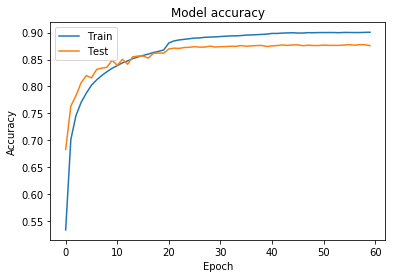

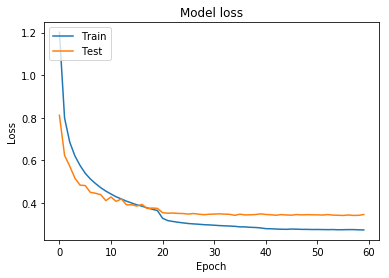

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/lstm_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/lstm_loss.png')
plt.show()